In [1]:
import numpy as np
import crispr_assembler as ca
import matplotlib.pyplot as plt
import editdistance as ed
import os
import pickle

import tqdm


%load_ext autoreload
%autoreload 2

In [2]:
path = '/home/anton/BigMac/skoltech/CRISPR_research/data/environmental/'
folders = sorted(os.listdir(path))[:3]

In [3]:
folders

['c1', 'r6', 'slv1']

In [4]:
res = []

for folder in folders[:5]:
    files = os.listdir(path + folder + "/out/pairs/")
    res.append(ca.restore(path + folder + "/out/pairs/" + files[0], 5))

100%|██████████| 321/321 [00:00<00:00, 3211.06it/s]


In [5]:
files

['SlV1_GTGGCC_L001_R1_001.fastq.gz_pairs.txt',
 'SlV1_GTGGCC_L001_R2_001.fastq.gz_pairs.txt']

In [6]:
grs = [x.graph_from_pairs()[0] for x in tqdm.tqdm(res)]

100%|██████████| 3/3 [00:09<00:00,  3.26s/it]


In [7]:
cut = 150
grs_cut = [x[:cut, :cut] for x in grs]

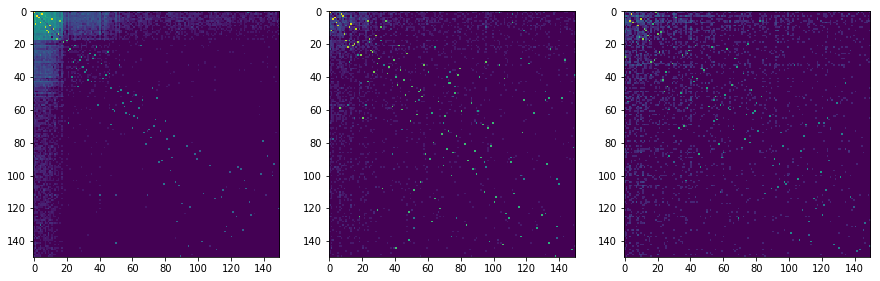

In [8]:
ca.plot_grs(*grs_cut,  log=1, s =15)

In [9]:
ec = ca.EmbeddingsCalculator()

In [10]:
embs = []
for gr in tqdm.tqdm(grs):
    ec = ca.EmbeddingsCalculator()
    embs.append(ec.fit_predict(gr))

100%|██████████| 3/3 [00:20<00:00,  6.69s/it]


In [11]:
gb = pickle.load(open("./lr_rep_to_rep", "rb"))

In [12]:
pred_grs = [gb.predict(emb).reshape(gr.shape) for emb, gr in zip(embs, grs)]

In [13]:
cut = 150
pred_grs_cut = [x[:cut, :cut] for x in pred_grs]

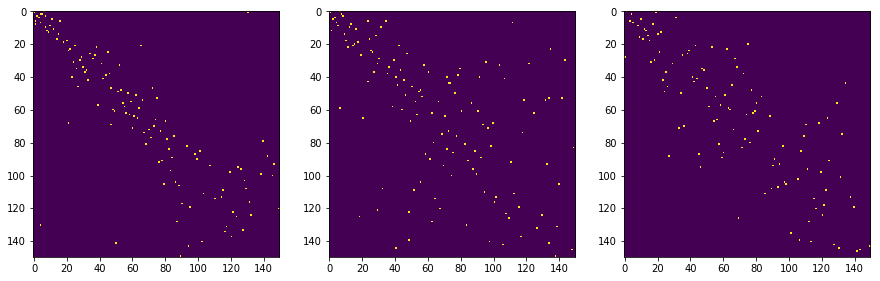

In [14]:
ca.plot_grs(*pred_grs_cut,  log=1, s =15)

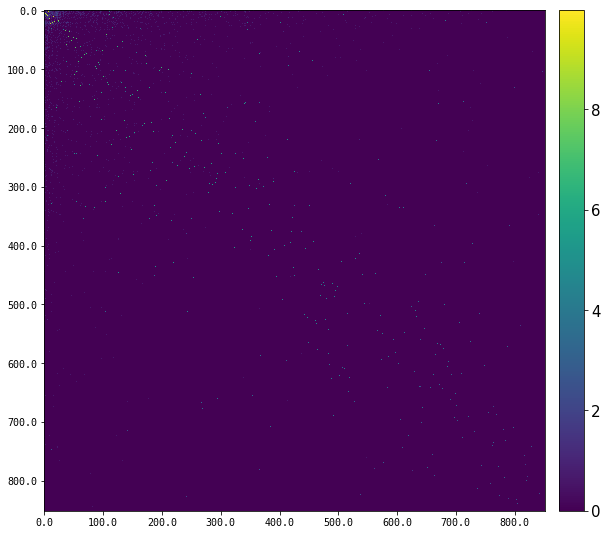

In [15]:
ca.plot_gr(grs[1],  log=1, s =15)

In [16]:
[x.shape for x in pred_grs]

[(283, 283), (852, 852), (297, 297)]

In [17]:
from importlib import reload
ca = reload(ca)

In [18]:
cut = 200
pred_grs_cut = [x[:cut, :cut] for x in pred_grs]

arrs = [[x for x in ca.restore_arrays_all(pred_grs[0])[1] if len(x) > 2], 
        [x for x in ca.restore_arrays_greedy(pred_grs[1])[0] if len(x) > 2],
        [x for x in ca.restore_arrays_all(pred_grs[2])[1] if len(x) > 2]]

#arrs = [[x for x in ca.restore_arrays_all(x)[1] if len(x) > 2] for x in tqdm.tqdm(pred_grs_cut)]

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

In [70]:
[len(x) for x in arrs]

[38, 104, 31]

In [71]:
def sort_names(names, keys_order = ['first', 'second', 'soft', 'greedy']): 
    order = np.argsort(names)
    
    names_presorted = np.array(names)[order]
    
    new_order = []
    key_to_color = dict(zip(keys_order, ['g','y','r','m']))
    colors = []
    
    for key in keys_order:
        for name, idx in zip(names_presorted, order):
            if name.split("_")[0] == key:
                new_order.append(idx)
                colors.append(key_to_color[key])
                
                
    return np.array(new_order), colors
    

In [72]:
def create_combined_array(alignments):
    combined = []
    i, j = 0, 0
    
    while j < len(alignments[0]): 
        if alignments[i][j] != '-':
            combined.append(alignments[i][j])
            j += 1
        else:
            i += 1
            i = i % len(alignments)
    
    return combined

In [73]:
def get_links(arrs):
    max_len = max([len(x) for x in arrs])
    arrs_np = np.ones((len(arrs), max_len)).astype(int) * -1
    
    for i, a in enumerate(arrs):
        arrs_np[i][:len(a)] = np.array(a)
    
    
    #return arrs_np

    links = [[] for x in range(len(arrs))]
    for i, a in enumerate(arrs):
        for j, x in enumerate(a):
            mask = np.where(arrs_np == x)
            #print(i, j, mask)
            local_links = []
            for i1, j1 in zip(mask[0], mask[1]):
                if i1 != i or j1 != j:
                    local_links.append((i1, j1))
            links[i].append(local_links)
            
    return links, arrs_np
    

In [74]:
def align(arrs, arrs_np, links, v = 0, max_iter=50):
    new_arrs = [[] for x in range(len(arrs))]
    pointers = [[i, 0] for i in range(len(arrs))]
    lens = [len(a) for a in arrs]

    def should_continue(pointers):
        if all([pointers[i][1] == lens[i] - 1 for i in range(len(arrs))]):
            return False
        else:
            return True

    def pointer_movable(p, mask):
        return mask[p[0]]
    
    movable_pointers_mask = np.array([pointers[i][1] < len(arrs[i]) for i in range(len(arrs))])

    it = 0
    while any(movable_pointers_mask) and it < max_iter:
        if v:print("-------------------------")
        curr_links = []
        movable_pointers_mask = np.array([pointers[i][1] < len(arrs[i]) for i in range(len(arrs))])
        
        for p in pointers:
            if pointer_movable(p, movable_pointers_mask):
                curr_links.append(links[p[0]][p[1]])
            else:
                curr_links.append([])

        links_mask = np.array([len(l) == 0 for l in curr_links])

        if v:
            print('p', pointers)
            print('cl', curr_links)
            print('lm', links_mask)
            print('mpm', movable_pointers_mask)

        if any(np.logical_and(movable_pointers_mask, links_mask)):
            p_to_move = np.where(np.logical_and(movable_pointers_mask, links_mask))[0][0]
            p = pointers[p_to_move]

            for i in range(len(new_arrs)):
                if i == p[0]:
                    new_arrs[i].append(arrs[p[0]][p[1]])
                else:
                    new_arrs[i].append('-')

            pointers[p_to_move][1] += 1

        else:
            links_clusters = set()
            for l, p in zip(curr_links, pointers):
                l_copy = [x for x in l]
                l_copy.append(p)

                l_copy = tuple(frozenset([tuple(x) for x in l_copy]))
                if len(l_copy) > 1:
                    links_clusters.add(l_copy)

            pointers_set = set([tuple(x) for x in pointers])

            if v : 
                print('ps', pointers_set)
                print('lc', links_clusters)
        
            for s in links_clusters:
                good_set = True
                if v:print('s', s)
                for el in s:
                    #if v:print('el', el)
                    if not el in pointers_set:
                        good_set = False

                if good_set:
                    if v:print('s', s)
                    completed_arrs = []

                    for el in s:
                        if  movable_pointers_mask[el[0]]:
                            new_arrs[el[0]].append(arrs[el[0]][el[1]])
                        pointers[el[0]][1] += 1
                        completed_arrs.append(el[0])

                    for i in range(len(arrs)):
                        if not i in completed_arrs:
                            new_arrs[i].append('-')
                    break
        movable_pointers_mask = np.array([pointers[i][1] < len(arrs[i]) for i in range(len(arrs))])
        if v:
            for i in range(len(arrs)):
                print(pointers[i][1], len(arrs[i]), arrs[i])
        if v:print('p', pointers)
        if v:print('mpm', movable_pointers_mask)         
        if v:print('na', new_arrs)
        it += 1
    return new_arrs

In [75]:
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
import matplotlib.lines as mlines

In [76]:
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

cmap = get_cmap(151)

In [77]:
def draw_array(ax, array, cmap, x0, y0, step = 0.04):
    rectangles = []
    for i, a in enumerate(array):
        if a == '-':
        #if '-' in a:
            color = 'none'
        else:
            color = 'b'#cmap(a*16 % cmap.N)
        rectangles.append(Rectangle((x0 + i * step*2, y0), step*2, step,linewidth=1,
                                    edgecolor='black',
                                    facecolor=color,
                                    alpha = 0.3))
        plt.text(x0 + i * step*2, y0, a)

    for r in rectangles:
        ax.add_patch(r)
    return rectangles #rectangles

In [78]:
def draw_array_triangles(ax, array, cmap, x0, y0, mask = None, step = 0.04, color=None):
    rectangles = []
    for i, a in enumerate(array):
        if color is None:
            if not mask is None:
                if mask[i] == 0 :
                    color = 'none'
                elif mask[i] == 1:
                    color = 'g'
                elif mask[i] == 2:
                    color = 'yc'
            else:
                if a == '-':
                    color = 'none'
                else:
                    color = cmap(3)
        
        #import ipdb; ipdb.set_trace()
        if a != "-":
            rectangles.append(plt.Polygon([[x0 + i * step*2.5, y0],
                                           [x0 + (i + 1) * step*2.5, y0],
                                           [x0 + i * step*2.5 + 1.25*step,  y0 + step *1.1]],
                                      #edgecolor='black',
                                      facecolor=color,
                                      alpha = 0.5))
        else:
            rectangles.append(Rectangle((x0 + i * step*2.5, y0), step*2.5, step,linewidth=1,
                                    edgecolor='black',
                                    facecolor='none',
                                    alpha = 0.2))
            
        plt.text(x0 + i * step*2.5 + 0.2 * step, y0, a)

    for r in rectangles:
        ax.add_patch(r)
    return rectangles #rectangles

In [79]:
def draw_allignment(ax, seq, targets, base_key, keys, cmap, x0, y0, colors, step=0.04):
    rectangles = draw_array(ax, seq, cmap, x0, y0)
    plt.text(x0 - 10 * step, y0 , base_key)
    
    #plt.show()
    i = 0 
    for i, t in enumerate(targets[:]):
        mask = []
        for j in range(len(seq)):
            if seq[j] == t[j] and seq[j] == '-':
                mask.append(0)
            elif seq[j] == t[j]:
                mask.append(1)
            else:
                mask.append(2)


        rectangles = draw_array_triangles(ax, t, cmap, x0, y0 - (i+1) * step, mask, color = colors[i])
        plt.text(x0 - 10 * step, y0 - (i+1) * step, keys[i])
#         else:
#             rectangles = draw_array(ax, t,cmap, y0 - (i+1) * step)
    return y0 - (i+2) * step

In [80]:
def draw_array_rhombus(ax, array, cmap, x0, y0, mask = None, step = 0.04, color=None):
    rectangles = []
    top_vertexes = []
    bottom_vertexes = []
    for i, a in enumerate(array):
        if color is None:
            if not mask is None:
                if mask[i] == 0 :
                    color = 'none'
                elif mask[i] == 1:
                    color = 'g'
                elif mask[i] == 2:
                    color = 'yc'
            else:
                if a == '-':
                    color = 'none'
                else:
                    color = cmap(3)
        
        #import ipdb; ipdb.set_trace()
        if a != "-":
            rectangles.append(plt.Polygon([[x0 + i * step*2.5, y0],
                                           [x0 + i * step*2.5 + 1.25*step,  y0 + step *0.55],
                                           [x0 + (i + 1) * step*2.5, y0],
                                           [x0 + i * step*2.5 + 1.25*step,  y0 - step *0.55]
                                           ],
                                      #edgecolor='black',
                                      facecolor=color,
                                      alpha = 0.5))
            
        else:
            rectangles.append(Rectangle((x0 + i * step*2.5, y0 - step *0.55), step*2.5, step,linewidth=1,
                                    edgecolor='black',
                                    facecolor='none',
                                    alpha = 0.2))
        
        top_vertexes.append([x0 + i * step*2.5 + 1.25*step,  y0 + step *0.55])
        bottom_vertexes.append([x0 + i * step*2.5 + 1.25*step,  y0 - step *0.55])
            
        plt.text(x0 + i * step*2.5 + 0.2 * step, y0, a)

    for r in rectangles:
        ax.add_patch(r)
    return rectangles, top_vertexes, bottom_vertexes

In [81]:
def draw_allignment_w_links(ax, arrs, links, keys, cmap, x0, y0, colors, step=0.04):
#     rectangles = draw_array(ax, seq, cmap, x0, y0)
#     plt.text(x0 - 10 * step, y0 , base_key)
    
    #plt.show()
    
    all_top_vertexes = []
    all_bottom_vertexes = []
    i = 0 
    for i, t in enumerate(arrs[:]):
#         mask = []
#         for j in range(len(seq)):
#             if seq[j] == t[j] and seq[j] == '-':
#                 mask.append(0)
#             elif seq[j] == t[j]:
#                 mask.append(1)
#             else:
#                 mask.append(2)


        rectangles, tv, bv = draw_array_rhombus(ax, t, cmap, x0, y0 - (i+1) * step   *1.5, color = colors[i])
        all_top_vertexes.append(tv)
        all_bottom_vertexes.append(bv)
        
    
    
    for bv, tv, l in zip(all_bottom_vertexes[:-1], all_top_vertexes[1:], links):
        for el in l:
            print(l, len(bv), len(tv))
            #print("drawing", el,tv[el[0]],  bv[el[1]])
            p1, p2 = tv[el[1]], bv[el[0]]
            line = mlines.Line2D([p1[0], p2[0]], [p1[1], p2[1]])
            ax.add_line(line)
            
        
        
        plt.text(x0 - 10 * step, y0 - (i+1) * step  *1.5, keys[i])
#         else:
#             rectangles = draw_array(ax, t,cmap, y0 - (i+1) * step)
    return y0 - (i+2) * step

In [83]:
def get_links(arrs):
    max_len = max([len(x) for x in arrs])
    arrs_np = np.ones((len(arrs), max_len)).astype(int) * -1
    
    for i, a in enumerate(arrs):
        arrs_np[i][:len(a)] = np.array(a)
    
    
    #return arrs_np

    links = [[] for x in range(len(arrs))]
    for i, a in enumerate(arrs):
        for j, x in enumerate(a):
            mask = np.where(arrs_np == x)
            #print(i, j, mask)
            local_links = []
            for i1, j1 in zip(mask[0], mask[1]):
                if i1 != i or j1 != j:
                    local_links.append((i1, j1))
            links[i].append(local_links)
            
    return links, arrs_np
    

In [90]:
arrs_ = [[1,2,3,4,5], [1,3,4,8,9], [3,'-','-',7,8,9]]

[[0, 0], [2, 1], [3, 2]] 5 5
[[0, 0], [2, 1], [3, 2]] 5 5
[[0, 0], [2, 1], [3, 2]] 5 5
[[1, 0], [3, 4], [4, 5]] 5 6
[[1, 0], [3, 4], [4, 5]] 5 6
[[1, 0], [3, 4], [4, 5]] 5 6


0.04000000000000001

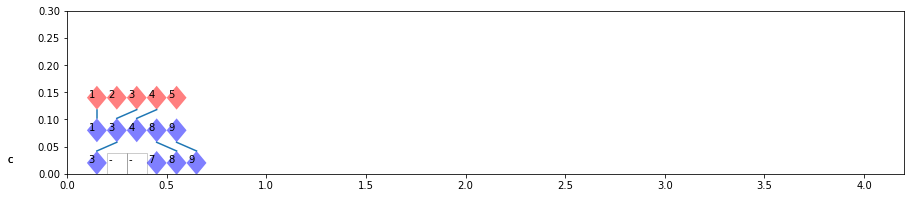

In [17]:
fig, ax = plt.subplots(1, figsize = (15,3))
ax.set_xlim(0,4.2)
ax.set_ylim(0,0.3)
y0 = 0.3

#draw_array_rhombus(ax, arrs[0], cmap, 0.1, 0.2,)
draw_allignment_w_links(ax, arrs, [[[0,0], [2,1], [3,2]], [[1,0], [3,4],[4,5]]], ['a', 'b', 'c'], cmap, 0.1, 0.2, ['r', 'b', 'b'])

In [ ]:
fig, ax = plt.subplots(1, figsize = (15,0.7 * len (candidates)))
ax.set_xlim(0,4.2)
ax.set_ylim(0,0.1 * len(candidates))
y0 = len(candidates) * 0.1 - 0.1

seen_keys = set()

for k,v in zip(['cat_14'], [[122, 130, 131, 85, 12, 24, 25]]): #list(candidates.items())[:]:  
    if k not in seen_keys:
        alignments = ca.water_alignments_dict(v, candidates)
        aligned_keys = sorted(list(alignments.keys()))
        aligned_arrs = [alignments[x] for x in aligned_keys]

        aligned_seqs = ca.process_multiple_alignments(aligned_arrs)
        s, t =  ca.preprint_multiple_alignments(aligned_seqs)   
        #y0 = draw_allignment(ax, s, t, k, keys, cmap, 0.4, y0)
#         links, arrs_np = get_links(aligned_arrs)
#         new_arrs = align(aligned_arrs, arrs_np, links)

#         combined = create_combined_array(new_arrs)

        order,colors = sort_names(aligned_keys, ['cat', 'new', 'vesna'])
        t = np.array(t)
        aligned_keys = np.array(aligned_keys)
        
        for key in aligned_keys:
            seen_keys.add(key)


        y0 = draw_allignment(ax, [], list(t[order]), '',  aligned_keys[order], cmap, 0.4, y0, colors)
        y0 -= 0.05

#fig.savefig("../../article/pics/cluster_alignments/" + str(idx) + '.png')
# #plt.show()

#dict_keys(['second_21', 'second_65', 'second_7', 'second_9', 'restored_1', 'restored_2', 'restored_15'])

In [ ]:
a

In [87]:
arrs_spacers = []

for a, r in zip(arrs, res):
    new_a = []
    for el in a: 
        new_a.append([r.index_to_cluster[x] for x in el])
    arrs_spacers.append(new_a)

TypeError: 'int' object is not iterable

In [88]:
ec = ca.ErrorCorrector(5)

In [253]:
ec.fit(ca.unwrap_nested(arrs_spacers, 2))

100%|██████████| 963/963 [00:01<00:00, 865.04it/s] 


In [254]:
arrs_corrected = []

for a in arrs_spacers:
    new_a = []
    for el in a:
        new_a.append([ec.spacer_to_cluster_index[x] for x in el])
    arrs_corrected.append(new_a)

In [255]:
keys = ['cat', 'new_slon', 'vesna_slon']

In [59]:
candidates = {}

#for k, a in zip(keys[:1] + keys[2:], arrs[:1] + arrs[2:]):
for k, a in zip(keys[1:], arrs[1:]):
    #print(a)
    for i, el in enumerate(a):
        candidates[k + "_" + str(i)] = el

In [256]:
candidates = {}

#for k, a in zip(keys[:1] + keys[2:], arrs[:1] + arrs[2:]):
for k, a in zip(keys, arrs_corrected):
    #print(a)
    for i, el in enumerate(a):
        candidates[k + "_" + str(i)] = el

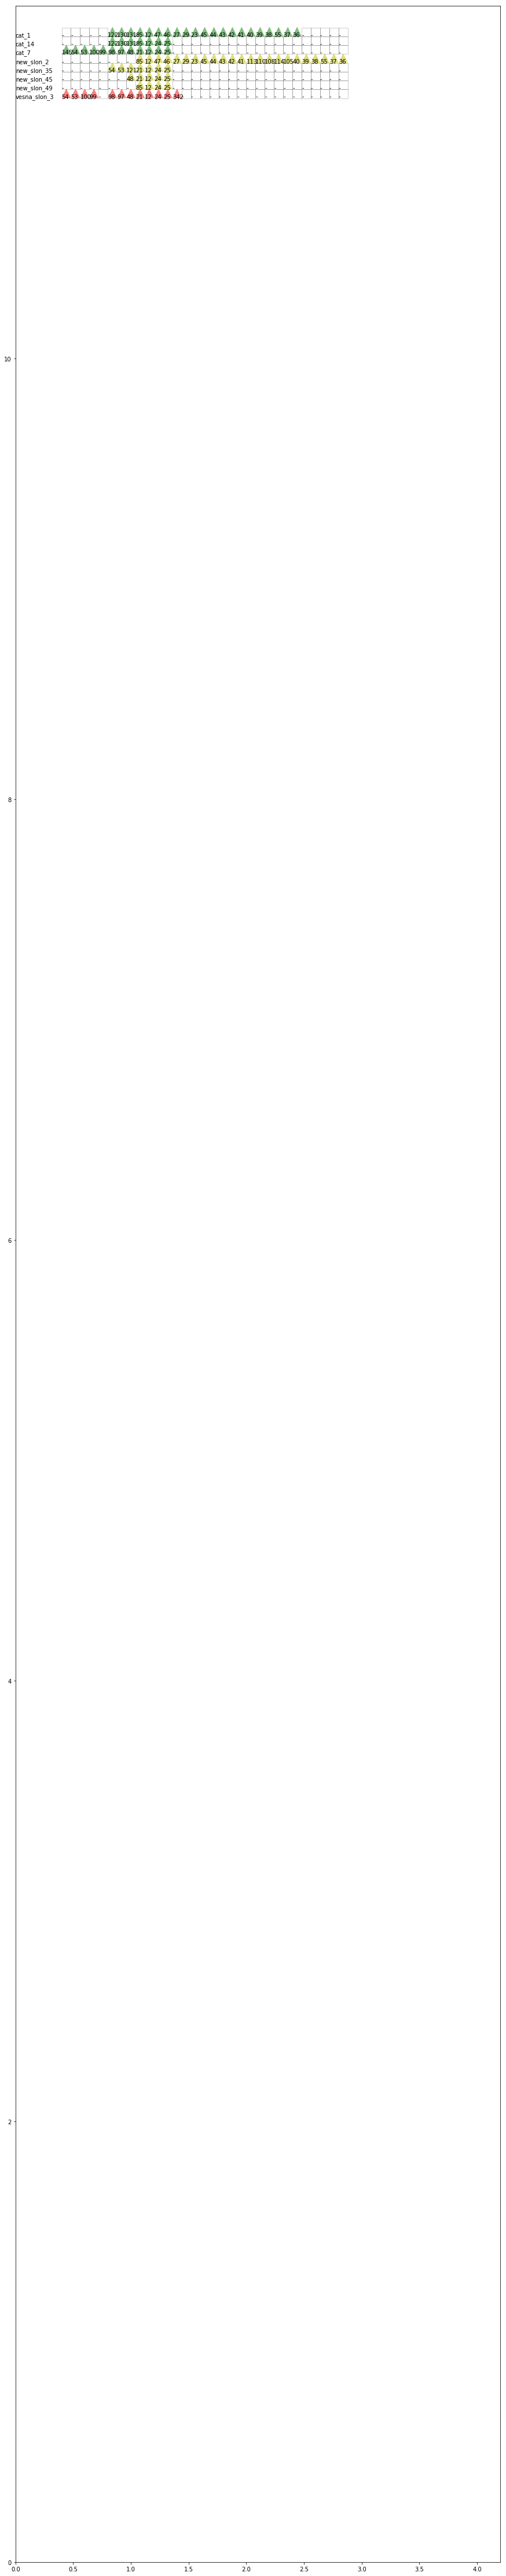

In [93]:
fig, ax = plt.subplots(1, figsize = (15,0.7 * len (candidates)))
ax.set_xlim(0,4.2)
ax.set_ylim(0,0.1 * len(candidates))
y0 = len(candidates) * 0.1 - 0.1

seen_keys = set()

for k,v in zip(['cat_14'], [[122, 130, 131, 85, 12, 24, 25]]): #list(candidates.items())[:]:  
    if k not in seen_keys:
        alignments = ca.water_alignments_dict(v, candidates)
        aligned_keys = sorted(list(alignments.keys()))
        aligned_arrs = [alignments[x] for x in aligned_keys]

        aligned_seqs = ca.process_multiple_alignments(aligned_arrs)
        s, t =  ca.preprint_multiple_alignments(aligned_seqs)   
        #y0 = draw_allignment(ax, s, t, k, keys, cmap, 0.4, y0)
#         links, arrs_np = get_links(aligned_arrs)
#         new_arrs = align(aligned_arrs, arrs_np, links)

#         combined = create_combined_array(new_arrs)

        order,colors = sort_names(aligned_keys, ['cat', 'new', 'vesna'])
        t = np.array(t)
        aligned_keys = np.array(aligned_keys)
        
        for key in aligned_keys:
            seen_keys.add(key)


        y0 = draw_allignment(ax, [], list(t[order]), '',  aligned_keys[order], cmap, 0.4, y0, colors)
        y0 -= 0.05

#fig.savefig("../../article/pics/cluster_alignments/" + str(idx) + '.png')
# #plt.show()

#dict_keys(['second_21', 'second_65', 'second_7', 'second_9', 'restored_1', 'restored_2', 'restored_15'])

In [95]:
ca.preprint_multiple_alignments(aligned_seqs, 1)

 -  ,
 -  ,
 -  ,
 145,
 -  ,
 -  ,
 -  ,
 -  ,
 54 ,
[0 0 1 0 0 0 0 1] [21, 7, 12, 26, 7, 7, 7, 12]
-----
 -  , -  ,
 -  , -  ,
 -  , -  ,
 145, 54 ,
 -  , -  ,
 -  , -  ,
 -  , -  ,
 -  , -  ,
 54 , 53 ,
[0 0 2 0 0 0 0 2] [21, 7, 12, 26, 7, 7, 7, 12]
-----
 -  , -  , -  ,
 -  , -  , -  ,
 -  , -  , -  ,
 145, 54 , 53 ,
 -  , -  , -  ,
 -  , -  , -  ,
 -  , -  , -  ,
 -  , -  , -  ,
 54 , 53 , 100,
[0 0 3 0 0 0 0 3] [21, 7, 12, 26, 7, 7, 7, 12]
-----
 -  , -  , -  , -  ,
 -  , -  , -  , -  ,
 -  , -  , -  , -  ,
 145, 54 , 53 , 100,
 -  , -  , -  , -  ,
 -  , -  , -  , -  ,
 -  , -  , -  , -  ,
 -  , -  , -  , -  ,
 54 , 53 , 100, 99 ,
[0 0 4 0 0 0 0 4] [21, 7, 12, 26, 7, 7, 7, 12]
-----
 -  , -  , -  , -  , -  ,
 -  , -  , -  , -  , -  ,
 -  , -  , -  , -  , -  ,
 145, 54 , 53 , 100, 99 ,
 -  , -  , -  , -  , -  ,
 -  , -  , -  , -  , -  ,
 -  , -  , -  , -  , -  ,
 -  , -  , -  , -  , -  ,
 54 , 53 , 100, 99 , -  ,
[0 0 5 0 0 0 0 4] [21, 7, 12, 26, 7, 7, 7, 12]
-----
 -  , -  , -  ,

(['-',
  '-',
  '-',
  '-',
  '-',
  122,
  130,
  131,
  85,
  12,
  24,
  25,
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-'],
 [['-',
   '-',
   '-',
   '-',
   '-',
   122,
   130,
   131,
   85,
   12,
   47,
   46,
   27,
   29,
   23,
   45,
   44,
   43,
   42,
   41,
   40,
   39,
   38,
   55,
   37,
   36,
   '-',
   '-',
   '-',
   '-',
   '-'],
  ['-',
   '-',
   '-',
   '-',
   '-',
   122,
   130,
   131,
   85,
   12,
   24,
   25,
   '-',
   '-',
   '-',
   '-',
   '-',
   '-',
   '-',
   '-',
   '-',
   '-',
   '-',
   '-',
   '-',
   '-',
   '-',
   '-',
   '-',
   '-',
   '-'],
  [145,
   54,
   53,
   100,
   99,
   98,
   97,
   48,
   21,
   12,
   24,
   25,
   '-',
   '-',
   '-',
   '-',
   '-',
   '-',
   '-',
   '-',
   '-',
   '-',
   '-',
   '-',
   '-',
   '-',
   '-',
   '-',
   '-',
   '-',
   '-'],
  ['-',
   '-',
   '-',
   '-',
   '-',
   '-',
   '-',
   '-',
   85,


In [88]:
candidates['vesna_slon_3']

[54, 53, 100, 99, 98, 97, 48, 21, 12, 24, 25, 342]

In [84]:
candidates['cat_14']

[122, 130, 131, 85, 12, 24, 25]

In [71]:
len(set(res[2].cluster_to_index.keys()).intersection(set(list(res[1].cluster_to_index.keys())[:200])))

104

In [257]:
arrs_spacers = []

for a, r in zip(arrs, res):
    new_a = []
    for el in a: 
        new_a.append([r.index_to_cluster[x] for x in el])
    arrs_spacers.append(new_a)

In [258]:
ec = ca.ErrorCorrector(5)

In [259]:
ec.fit(ca.unwrap_nested(arrs_spacers, 2))

100%|██████████| 963/963 [00:01<00:00, 849.93it/s] 


In [260]:
arrs_corrected = []

for a in arrs_spacers:
    new_a = []
    for el in a:
        new_a.append([ec.spacer_to_cluster_index[x] for x in el])
    arrs_corrected.append(new_a)

In [261]:
[len(x.cluster_to_index) for x in res]

[282, 851, 296]

In [175]:
candidates = {'cat_' : [3,4], 'new_' : [0, 1,2,3,4], 'vesna_': [1,2,3,4]}

In [171]:
candidates = {'cat_' : [3,4], 'new_' : [0, 1,2,3,4], 'vesna_': [2,0,1,3,4]}

In [262]:
keys = ['cat', 'new_slon', 'vesna_slon']
candidates = {}

#for k, a in zip(keys[:1] + keys[2:], arrs[:1] + arrs[2:]):
for k, a in zip(keys, arrs_corrected):
    #print(a)
    for i, el in enumerate(a):
        candidates[k + "_" + str(i)] = el

In [263]:

macro_lens = []
macro_keys = []
macro_vals = []
for k,v in candidates.items():
    macro_lens.append(len(v))
    macro_vals.append(v)
    macro_keys.append(k)

macro_lens = np.array(macro_lens)
macro_keys = np.array(macro_keys)
macro_vals = np.array(macro_vals)

macro_order = np.argsort(macro_lens)[::-1]


## FINAL

In [270]:
ts, ks, cs = [], [], []

In [271]:
seen_keys = set()

for k,v in zip(macro_keys[macro_order], macro_vals[macro_order]): #list(candidates.items())[:]:  #zip(['cat_14'], [[122, 130, 131, 85, 12, 24, 25]]): #list(candidates.items())[:]:  
    if k not in seen_keys:
        alignments = ca.water_alignments_dict(v, candidates)
        aligned_keys = sorted(list(alignments.keys()))
        aligned_arrs = [alignments[x] for x in aligned_keys]

        aligned_seqs = ca.process_multiple_alignments(aligned_arrs)
        s, t =  ca.preprint_multiple_alignments(aligned_seqs)   
        #y0 = draw_allignment(ax, s, t, k, keys, cmap, 0.4, y0)
#         links, arrs_np = get_links(aligned_arrs)
#         new_arrs = align(aligned_arrs, arrs_np, links)

#         combined = create_combined_array(new_arrs)

        order,colors = sort_names(aligned_keys, ['cat', 'new', 'vesna'])
        t = np.array(t)
        aligned_keys = np.array(aligned_keys)
        
        for key in aligned_keys:
            seen_keys.add(key)

        ts.append(list(t[order]))
        ks.append(aligned_keys[order])
        cs.append(colors)
#         y0 = draw_allignment(ax, [], list(t[order]), '',  aligned_keys[order], cmap, 0.4, y0, colors)
#         y0 -= 0.05

#fig.savefig("../../article/pics/cluster_alignments/" + str(idx) + '.png')
# #plt.show()

#dict_keys(['second_21', 'second_65', 'second_7', 'second_9', 'restored_1', 'restored_2', 'restored_15'])

In [288]:
ts, ks, cs = np.array(ts), np.array(ks), np.array(cs)

In [284]:
macro_order = np.argsort([len(x) for x in ts])[::-1]
mask = np.array([len(x) for x in ts])[macro_order] > 1

In [299]:
tail_keys = [x[0] for x in ks[macro_order][np.logical_not(mask)]]

In [302]:
tail_order, tail_colors = sort_names(tail_keys, ['cat', 'new', 'vesna'])

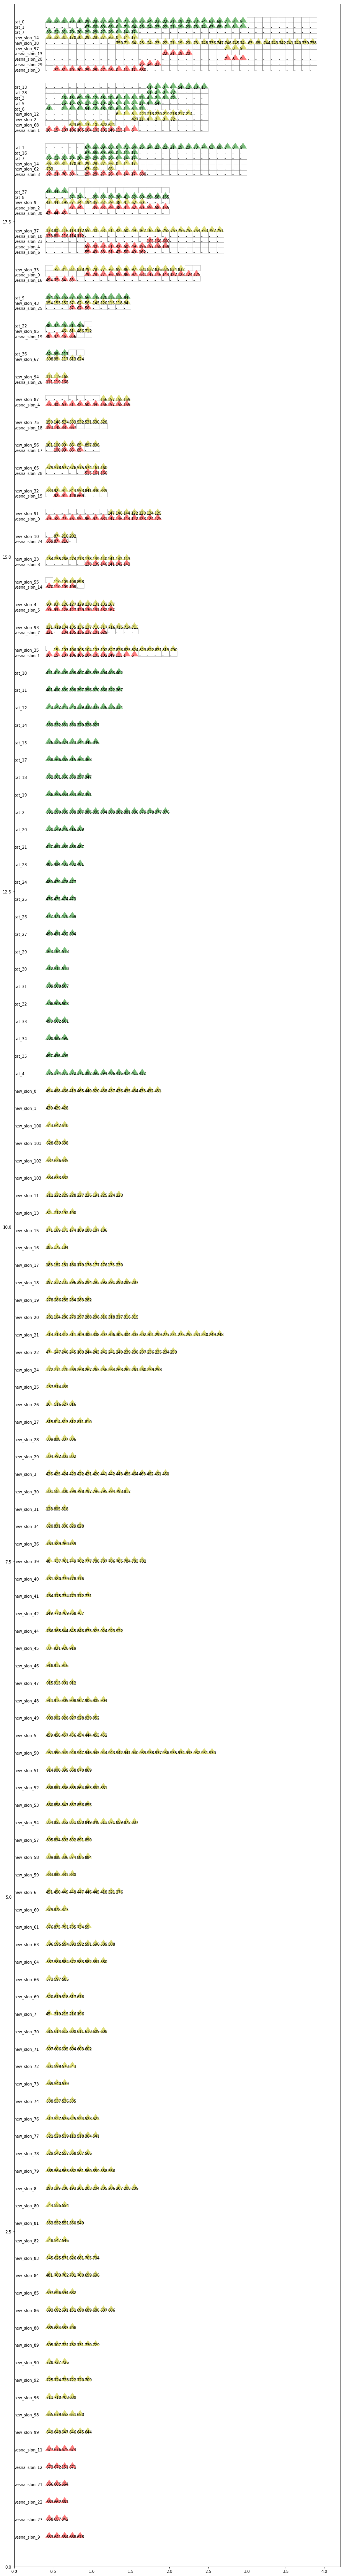

In [324]:
fig, ax = plt.subplots(1, figsize = (15,0.7* len (candidates)))
ax.set_xlim(0,4.2)
ax.set_ylim(0,0.125 * len(candidates) - 2.5)
y0 = len(candidates) * 0.125 - 0.1 - 2.5


for t, k, c in zip(np.array(ts)[macro_order][mask],
                   np.array(ks)[macro_order][mask],
                   np.array(cs)[macro_order][mask]):
    y0 = draw_allignment(ax, [], list(t), '',  k, cmap, 0.4, y0, c)
    y0 -= 0.05
    
for t, k, c in zip(np.array(ts)[macro_order][np.logical_not(mask)][tail_order],
                   np.array(ks)[macro_order][np.logical_not(mask)][tail_order],
                   np.array(cs)[macro_order][np.logical_not(mask)][tail_order]):
    y0 = draw_allignment(ax, [], list(t), '',  k, cmap, 0.4, y0, c)
    y0 -= 0.05

In [325]:
15 ** 10 

576650390625

In [277]:
for a,b,c in zip([1,2],[2,3],[3,4]):
    print(a,b,c)

1 2 3
2 3 4


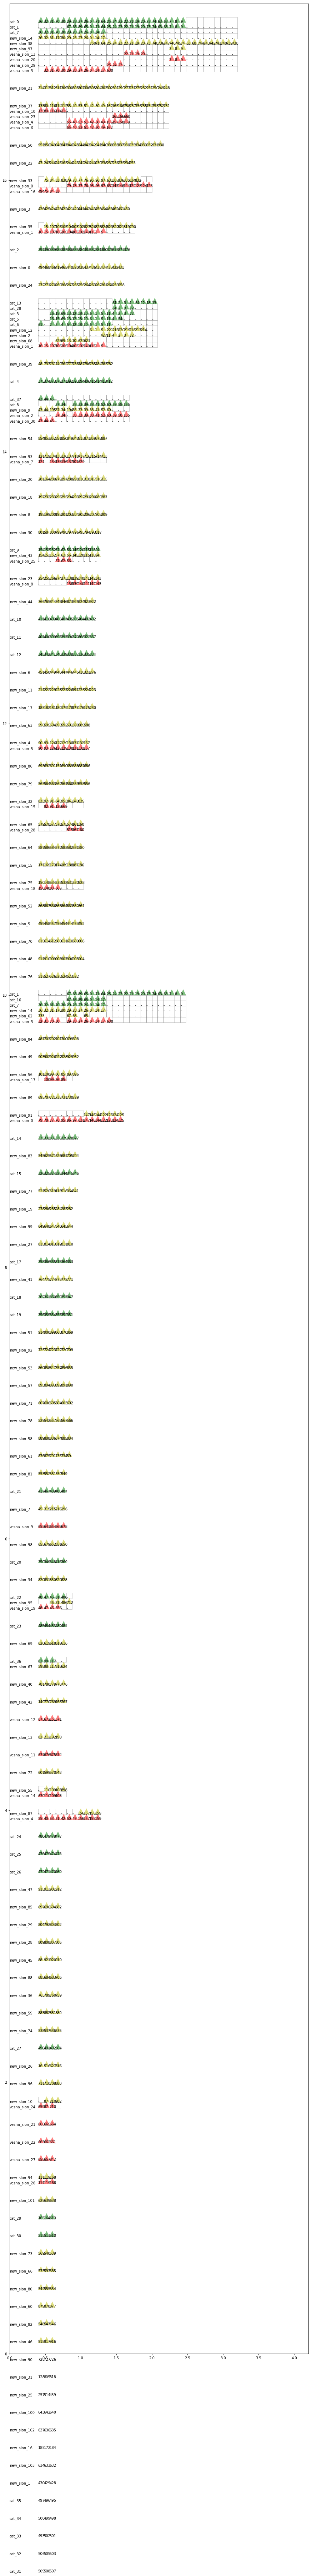

In [268]:
fig, ax = plt.subplots(1, figsize = (15,0.7* len (candidates)))
ax.set_xlim(0,4.2)
ax.set_ylim(0,0.1 * len(candidates))
y0 = len(candidates) * 0.1 - 0.1

seen_keys = set()

for k,v in zip(macro_keys[macro_order], macro_vals[macro_order]): #list(candidates.items())[:]:  #zip(['cat_14'], [[122, 130, 131, 85, 12, 24, 25]]): #list(candidates.items())[:]:  
    if k not in seen_keys:
        alignments = ca.water_alignments_dict(v, candidates)
        aligned_keys = sorted(list(alignments.keys()))
        aligned_arrs = [alignments[x] for x in aligned_keys]

        aligned_seqs = ca.process_multiple_alignments(aligned_arrs)
        s, t =  ca.preprint_multiple_alignments(aligned_seqs)   
        #y0 = draw_allignment(ax, s, t, k, keys, cmap, 0.4, y0)
#         links, arrs_np = get_links(aligned_arrs)
#         new_arrs = align(aligned_arrs, arrs_np, links)

#         combined = create_combined_array(new_arrs)

        order,colors = sort_names(aligned_keys, ['cat', 'new', 'vesna'])
        t = np.array(t)
        aligned_keys = np.array(aligned_keys)
        
        for key in aligned_keys:
            seen_keys.add(key)


        y0 = draw_allignment(ax, [], list(t[order]), '',  aligned_keys[order], cmap, 0.4, y0, colors)
        y0 -= 0.05

#fig.savefig("../../article/pics/cluster_alignments/" + str(idx) + '.png')
# #plt.show()

#dict_keys(['second_21', 'second_65', 'second_7', 'second_9', 'restored_1', 'restored_2', 'restored_15'])

In [224]:
x = [1,2,3,4,5]
[[1,2,3] == x[i:i + 3] for i in range(len(x) - 3)]

[True, False]

In [232]:
x = [0,6,5]
mask = np.array([any([x == y[i:i + 3] for i in range(len(y) - 3)]) for y in macro_vals])

In [233]:
macro_vals[mask]

array([list([4, 30, 10, 11, 28, 9, 7, 8, 0, 6, 5, 3, 15, 16, 14, 13, 2, 1]),
       list([4, 30, 10, 11, 28, 9, 7, 8, 0, 6, 5, 3, 16, 14, 13, 2, 1]),
       list([4, 30, 10, 11, 9, 7, 8, 0, 6, 5, 3, 15, 16, 14, 13, 2, 1]),
       list([4, 10, 11, 28, 9, 7, 8, 0, 6, 5, 3, 15, 16, 14, 13, 2, 1]),
       list([4, 30, 10, 11, 9, 7, 8, 0, 6, 5, 3, 16, 14, 13, 2, 1]),
       list([4, 10, 11, 28, 9, 7, 8, 0, 6, 5, 3, 16, 14, 13, 2, 1]),
       list([4, 10, 11, 9, 7, 8, 0, 6, 5, 3, 15, 16, 14, 13, 2, 1]),
       list([4, 30, 10, 11, 28, 9, 7, 8, 0, 6, 5, 3, 15, 2, 1]),
       list([4, 10, 11, 9, 7, 8, 0, 6, 5, 3, 16, 14, 13, 2, 1]),
       list([4, 30, 10, 11, 9, 7, 8, 0, 6, 5, 3, 15, 2, 1]),
       list([4, 10, 11, 28, 9, 7, 8, 0, 6, 5, 3, 15, 2, 1]),
       list([4, 10, 11, 9, 7, 8, 0, 6, 5, 3, 15, 2, 1]),
       list([4, 0, 6, 5, 3, 15, 16, 14, 13, 2, 1]),
       list([4, 0, 6, 5, 3, 16, 14, 13, 2, 1]),
       list([4, 0, 6, 5, 3, 15, 2, 1])], dtype=object)

In [234]:
macro_keys[mask]

array(['new_slon_3', 'new_slon_4', 'new_slon_5', 'new_slon_6',
       'new_slon_7', 'new_slon_8', 'new_slon_9', 'new_slon_10',
       'new_slon_11', 'new_slon_14', 'new_slon_15', 'new_slon_18',
       'new_slon_25', 'new_slon_26', 'new_slon_30'], dtype='<U13')

In [219]:
macro_vals

array([list([145, 54, 53, 100, 99, 98, 97, 48, 21, 12, 47, 46, 27, 29, 23, 45, 44, 43, 42, 41, 40, 39, 38, 55, 37, 36]),
       list([122, 130, 131, 85, 12, 47, 46, 27, 29, 23, 45, 44, 43, 42, 41, 40, 39, 38, 55, 37, 36]),
       list([250, 275, 274, 273, 272, 271, 270, 269, 268, 267, 266, 265, 264, 263, 262, 261]),
       list([93, 78, 129, 79, 88, 83, 82, 90, 34, 81, 80, 33, 32, 31, 137]),
       list([93, 78, 129, 79, 88, 83, 82, 90, 34, 81, 80, 33, 89]),
       list([91, 32, 31, 33, 89, 88, 83, 82, 90, 34, 81, 80]),
       list([170, 166, 178, 177, 179, 180, 181, 182, 186, 188, 187, 184]),
       list([145, 54, 53, 100, 99, 98, 97, 48, 21, 12, 24, 25]),
       list([138, 139, 140, 141, 142, 143, 132, 128, 92, 118, 117, 115]),
       list([104, 103, 136, 112, 84, 87, 111, 109, 107, 106, 102]),
       list([208, 207, 206, 204, 192, 203, 202, 201, 200, 199]),
       list([198, 197, 196, 195, 194, 193, 276, 255, 278, 308]),
       list([91, 32, 31, 33, 89, 88, 83, 79]),
       list([36

In [187]:
keys = ['cat', 'new_slon', 'vesna_slon']

In [188]:
candidates = {}

#for k, a in zip(keys[:1] + keys[2:], arrs[:1] + arrs[2:]):
for k, a in zip(keys, arrs_corrected):
    #print(a)
    for i, el in enumerate(a):
        candidates[k + "_" + str(i)] = el

KeyboardInterrupt: 

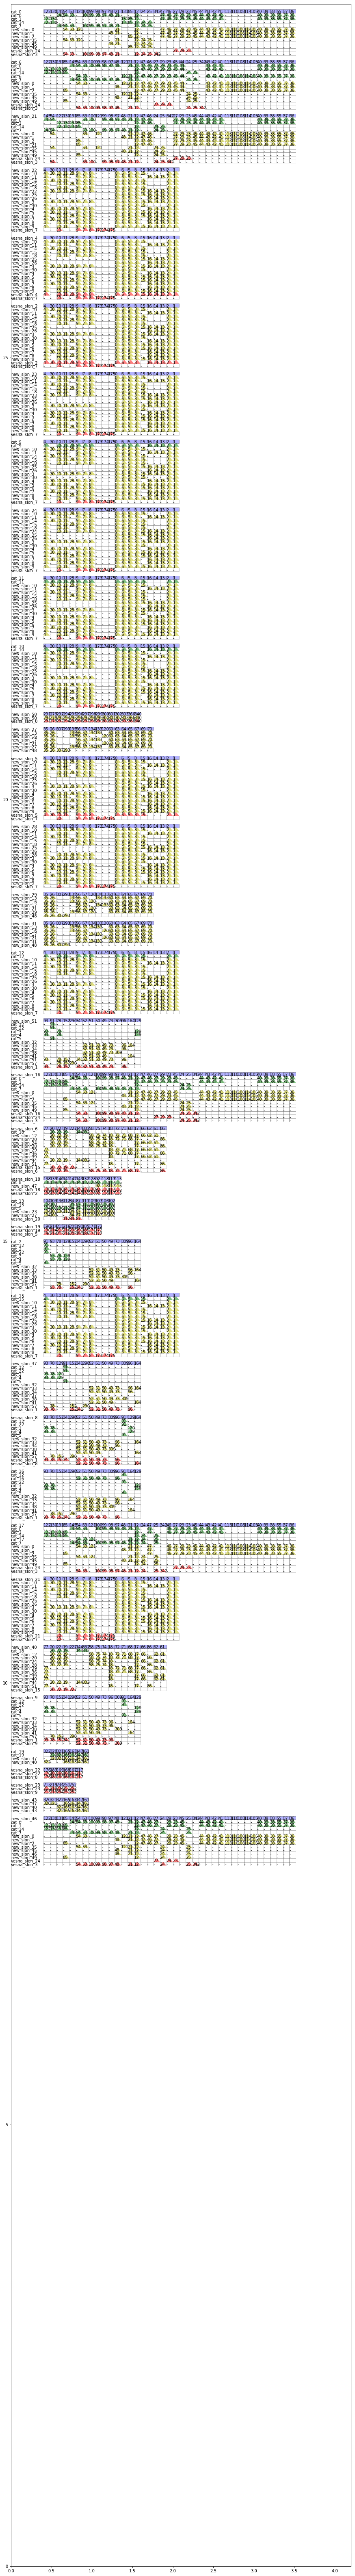

Process ForkPoolWorker-34:
Process ForkPoolWorker-30:
Process ForkPoolWorker-37:
Process ForkPoolWorker-32:
Process ForkPoolWorker-42:
Process ForkPoolWorker-46:
Process ForkPoolWorker-25:
Process ForkPoolWorker-44:
Process ForkPoolWorker-36:
Process ForkPoolWorker-28:
Process ForkPoolWorker-33:
Process ForkPoolWorker-40:
Traceback (most recent call last):
Process ForkPoolWorker-47:
Traceback (most recent call last):
Process ForkPoolWorker-35:
Process ForkPoolWorker-45:
Process ForkPoolWorker-43:
Process ForkPoolWorker-27:
Process ForkPoolWorker-31:
Process ForkPoolWorker-29:
Process ForkPoolWorker-41:
Process ForkPoolWorker-38:
Traceback (most recent call last):
Process ForkPoolWorker-48:
Process ForkPoolWorker-39:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-26:
Tr

  File "/home/anton/anaconda3/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/home/anton/anaconda3/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/home/anton/anaconda3/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/home/anton/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/anton/anaconda3/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/home/anton/anaconda3/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/home/anton/anaconda3/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/home/anton/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/anton/anaconda3/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  Fi

  File "/home/anton/anaconda3/lib/python3.6/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
  File "/home/anton/anaconda3/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/home/anton/anaconda3/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt


In [190]:
fig, ax = plt.subplots(1, figsize = (15,1 * len (candidates)))
ax.set_xlim(0,4.2)
ax.set_ylim(0,0.25 * len(candidates))
y0 = len(candidates) * 0.25 - 0.1


seen_keys = set()

for k,v in zip(keys[order], vals[order]): #list(candidates.items())[:]:  #zip(['cat_12'], [[161, 0, 6, 1, 130, 4, 3, 7]]):
    if not k in seen_keys:
        aligned_arrs = [v]
        aligned_keys = [k]
        curr_keys_pool = set()
        curr_keys_pool.add(k)
        search_candidates = [v]
        search = True

        #import ipdb; ipdb.set_trace() 
        max_iter = 0
        while search and max_iter < 10:
            search = False
            new_search_candidates = []
            for c in search_candidates:
                alignments = ca.water_alignments_dict(c, candidates)
                keys = sorted(list(alignments.keys()))

                for key in keys:
                    if not key in curr_keys_pool:
                        curr_keys_pool.add(key)
                        aligned_arrs.append(alignments[key][1])
                        aligned_keys.append(key)
                        search = True
                        new_search_candidates.append(candidates[key])   

            search_candidates = new_search_candidates
            max_iter += 1    

        for el in curr_keys_pool:
            seen_keys.add(el)

        #aligned_arrs_fixed = [fix_arr(el) for el in aligned_arrs]

        links, arrs_np = get_links(aligned_arrs)
        new_arrs = align(aligned_arrs, arrs_np, links)

        combined = create_combined_array(new_arrs)

        order,colors = sort_names(aligned_keys, ['cat', 'new', 'vesna'])
        new_arrs = np.array(new_arrs)
        aligned_keys = np.array(aligned_keys)


        y0 = draw_allignment(ax, combined, list(new_arrs[order]), k,  aligned_keys[order], cmap, 0.4, y0, colors)
        y0 -= 0.05

#fig.savefig("../../article/pics/cluster_alignments/" + str(idx) + '.png')
# #plt.show()

#dibct_keys(['second_21', 'second_65', 'second_7', 'second_9', 'restored_1', 'restored_2', 'restored_15'])

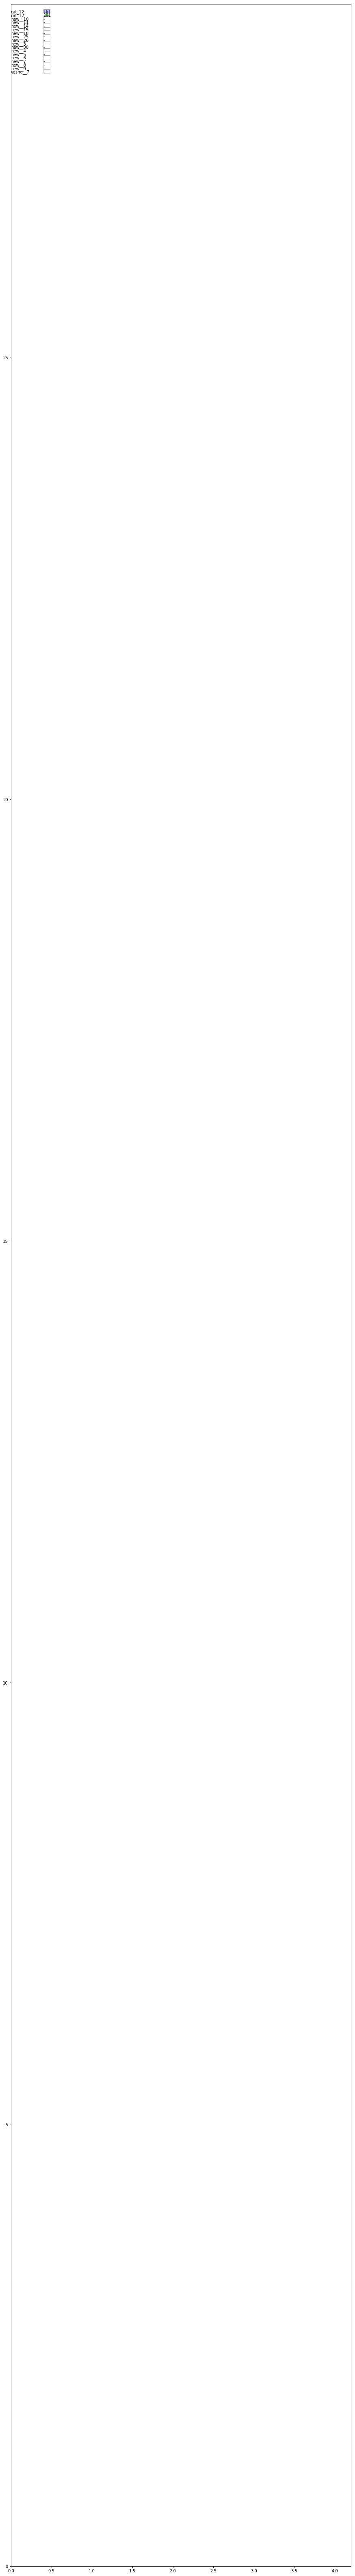

In [169]:
fig, ax = plt.subplots(1, figsize = (15,1 * len (candidates)))
ax.set_xlim(0,4.2)
ax.set_ylim(0,0.25 * len(candidates))
y0 = len(candidates) * 0.25 - 0.1


seen_keys = set()

for k,v in zip(['cat_12'], [[161, 0, 6, 1, 130, 4, 3, 7]]):
    if not k in seen_keys:
        aligned_arrs = [v]
        aligned_keys = [k]
        curr_keys_pool = set()
        curr_keys_pool.add(k)
        search_candidates = [v]
        search = True

        #import ipdb; ipdb.set_trace() 
        max_iter = 0
        while search and max_iter < 10:
            search = False
            new_search_candidates = []
            for c in search_candidates:
                alignments = ca.water_alignments_dict(c, candidates)
                keys = sorted(list(alignments.keys()))

                for key in keys:
                    if not key in curr_keys_pool:
                        curr_keys_pool.add(key)
                        aligned_arrs.append(alignments[key][1])
                        aligned_keys.append(key)
                        search = True
                        new_search_candidates.append(candidates[key])   

            search_candidates = new_search_candidates
            max_iter += 1    

        for el in curr_keys_pool:
            seen_keys.add(el)

        #aligned_arrs_fixed = [fix_arr(el) for el in aligned_arrs]

        links, arrs_np = get_links(aligned_arrs)
        new_arrs = align(aligned_arrs, arrs_np, links)

        combined = create_combined_array(new_arrs)

        order,colors = sort_names(aligned_keys, ['cat', 'new', 'vesna'])
        new_arrs = np.array(new_arrs)
        aligned_keys = np.array(aligned_keys)


        y0 = draw_allignment(ax, combined, list(new_arrs[order]), k,  aligned_keys[order], cmap, 0.4, y0, colors)
        y0 -= 0.05

#fig.savefig("../../article/pics/cluster_alignments/" + str(idx) + '.png')
# #plt.show()

#dibct_keys(['second_21', 'second_65', 'second_7', 'second_9', 'restored_1', 'restored_2', 'restored_15'])

In [154]:
aligned_arrs

[[161, 0, 6, 1, 130, 4, 3, 7],
 [4, 30, 10, 11, 28, 9, 7, 8, 0, 6, 5, 3, 15, 2, 1],
 [4, 10, 11, 9, 7, 8, 0, 6, 5, 3, 16, 14, 13, 2, 1],
 [4, 30, 10, 11, 9, 7, 8, 0, 6, 5, 3, 15, 2, 1],
 [4, 10, 11, 28, 9, 7, 8, 0, 6, 5, 3, 15, 2, 1],
 [4, 10, 11, 9, 7, 8, 0, 6, 5, 3, 15, 2, 1],
 [4, 0, 6, 5, 3, 15, 16, 14, 13, 2, 1],
 [4, 0, 6, 5, 3, 16, 14, 13, 2, 1],
 [4, 30, 10, 11, 28, 9, 7, 8, 0, 6, 5, 3, 15, 16, 14, 13, 2, 1],
 [4, 0, 6, 5, 3, 15, 2, 1],
 [4, 30, 10, 11, 28, 9, 7, 8, 0, 6, 5, 3, 16, 14, 13, 2, 1],
 [4, 30, 10, 11, 9, 7, 8, 0, 6, 5, 3, 15, 16, 14, 13, 2, 1],
 [4, 10, 11, 28, 9, 7, 8, 0, 6, 5, 3, 15, 16, 14, 13, 2, 1],
 [4, 30, 10, 11, 9, 7, 8, 0, 6, 5, 3, 16, 14, 13, 2, 1],
 [4, 10, 11, 28, 9, 7, 8, 0, 6, 5, 3, 16, 14, 13, 2, 1],
 [4, 10, 11, 9, 7, 8, 0, 6, 5, 3, 15, 16, 14, 13, 2, 1],
 [10, 9, 7, 8, 173, 174, 175]]

In [152]:
new_arrs

array([list([161, 0, 6, 1, 130, 4, 3, '-', 7, '-']),
       list(['-', '-', 4, 30, 10, 11, 28, 9, 7, 8, 0, 6, 5, 3, 15, 2, 1]),
       list(['-', '-', 4, '-', 10, 11, 9, 7, 8, 0, 6, 5, 3, 16, 14, 13, 2, 1]),
       list(['-', '-', 4, 30, 10, 11, 9, 7, 8, 0, 6, 5, 3, 15, 2, 1]),
       list(['-', '-', 4, '-', 10, 11, 28, 9, 7, 8, 0, 6]),
       list(['-', '-', 4, '-', 10]), list(['-', '-', 4, '-', '-']),
       list(['-', '-', 4, '-', '-']), list(['-', '-', 4, 30, 10]),
       list(['-', '-', 4, '-', '-']), list(['-', '-', 4, 30, 10]),
       list(['-', '-', 4, 30, 10]), list(['-', '-', 4, '-', 10]),
       list(['-', '-', 4, 30, 10]), list(['-', '-', 4, '-', 10]),
       list(['-', '-', 4, '-', 10]), list(['-', '-', '-', '-', 10])],
      dtype=object)

In [97]:
candidates['cat_12']

[91, 32, 31, 33, 89, 88, 83, 79]

In [129]:
links[0][0]

[]

In [177]:
def align(arrs, arrs_np, links, v = 0, max_iter=50):
    new_arrs = [[] for x in range(len(arrs))]
    pointers = [[i, 0] for i in range(len(arrs))]
    lens = [len(a) for a in arrs]

    def should_continue(pointers):
        if all([pointers[i][1] == lens[i] - 1 for i in range(len(arrs))]):
            return False
        else:
            return True

    def pointer_movable(p, mask):
        return mask[p[0]]
    
    def clean_links(links, link):
        for l in links:
            for el in l:
                if link in el:
                    el.remove(link)
    
    movable_pointers_mask = np.array([pointers[i][1] < len(arrs[i]) for i in range(len(arrs))])

    it = 0
    while any(movable_pointers_mask) and it < max_iter:
        if v:print("-------------------------")
        curr_links = []
        movable_pointers_mask = np.array([pointers[i][1] < len(arrs[i]) for i in range(len(arrs))])
        
        for p in pointers:
            if pointer_movable(p, movable_pointers_mask):
                curr_links.append(links[p[0]][p[1]])
            else:
                curr_links.append([])

        links_mask = np.array([len(l) == 0 for l in curr_links])

        if v:
            print('p', pointers)
            print('cl', curr_links)
            print('lm', links_mask)
            print('mpm', movable_pointers_mask)

        if any(np.logical_and(movable_pointers_mask, links_mask)):
            p_to_move = np.where(np.logical_and(movable_pointers_mask, links_mask))[0][0]
            p = pointers[p_to_move]

            for i in range(len(new_arrs)):
                if i == p[0]:
                    new_arrs[i].append(arrs[p[0]][p[1]])
                else:
                    new_arrs[i].append('-')

            pointers[p_to_move][1] += 1

        else:
            links_clusters = set()
            for l, p in zip(curr_links, pointers):
                l_copy = [x for x in l]
                l_copy.append(p)

                l_copy = tuple(frozenset([tuple(x) for x in l_copy]))
                if len(l_copy) > 1:
                    links_clusters.add(l_copy)

            pointers_set = set([tuple(x) for x in pointers])

            if v : 
                print('ps', pointers_set)
                print('lc', links_clusters)
            
            seen_good_set = False
            for s in links_clusters:
                good_set = True
                if v:print('s', s)
                for el in s:
                    #if v:print('el', el)
                    if not el in pointers_set:
                        good_set = False

                if good_set:
                    if v:print('s', s)
                    completed_arrs = []

                    for el in s:
                        if  movable_pointers_mask[el[0]]:
                            new_arrs[el[0]].append(arrs[el[0]][el[1]])
                        pointers[el[0]][1] += 1
                        completed_arrs.append(el[0])

                    for i in range(len(arrs)):
                        if not i in completed_arrs:
                            new_arrs[i].append('-')
                            
                    seen_good_set == True
                    break
            
#             if seen_good_set == False:
#                 #max_iter = 0
                
#                 if v: print("ASASA")
#                 pointer_to_move = pointers[np.where(movable_pointers_mask)[0][0]]
#                 if v: print(pointer_to_move)
                    
#                 for i in range(len(arrs)):
#                     if i == pointer_to_move[0]:
#                         new_arrs[pointer_to_move[0]].append(arrs[pointer_to_move[0]][pointer_to_move[1]])
#                         pointers[pointer_to_move[0]][1] += 1
#                         clean_links(links, pointer_to_move)
#                     else:
#                         new_arrs[i].append("-")
                
                
        movable_pointers_mask = np.array([pointers[i][1] < len(arrs[i]) for i in range(len(arrs))])
#         if v:
#             for i in range(len(arrs)):
#                 print(pointers[i][1], len(arrs[i]), arrs[i])
        if v:print('p', pointers)
        if v:print('mpm', movable_pointers_mask)         
        if v:print('na', new_arrs)
        it += 1
    return new_arrs

In [156]:
aligned_arrs

[[161, 0, 6, 1, 130, 4, 3, 7],
 [4, 30, 10, 11, 28, 9, 7, 8, 0, 6, 5, 3, 15, 2, 1],
 [4, 10, 11, 9, 7, 8, 0, 6, 5, 3, 16, 14, 13, 2, 1],
 [4, 30, 10, 11, 9, 7, 8, 0, 6, 5, 3, 15, 2, 1],
 [4, 10, 11, 28, 9, 7, 8, 0, 6, 5, 3, 15, 2, 1],
 [4, 10, 11, 9, 7, 8, 0, 6, 5, 3, 15, 2, 1],
 [4, 0, 6, 5, 3, 15, 16, 14, 13, 2, 1],
 [4, 0, 6, 5, 3, 16, 14, 13, 2, 1],
 [4, 30, 10, 11, 28, 9, 7, 8, 0, 6, 5, 3, 15, 16, 14, 13, 2, 1],
 [4, 0, 6, 5, 3, 15, 2, 1],
 [4, 30, 10, 11, 28, 9, 7, 8, 0, 6, 5, 3, 16, 14, 13, 2, 1],
 [4, 30, 10, 11, 9, 7, 8, 0, 6, 5, 3, 15, 16, 14, 13, 2, 1],
 [4, 10, 11, 28, 9, 7, 8, 0, 6, 5, 3, 15, 16, 14, 13, 2, 1],
 [4, 30, 10, 11, 9, 7, 8, 0, 6, 5, 3, 16, 14, 13, 2, 1],
 [4, 10, 11, 28, 9, 7, 8, 0, 6, 5, 3, 16, 14, 13, 2, 1],
 [4, 10, 11, 9, 7, 8, 0, 6, 5, 3, 15, 16, 14, 13, 2, 1],
 [10, 9, 7, 8, 173, 174, 175]]

In [157]:
align(aligned_arrs, arrs_np, links, v =1)

-------------------------
p [[0, 0], [1, 0], [2, 0], [3, 0], [4, 0], [5, 0], [6, 0], [7, 0], [8, 0], [9, 0], [10, 0], [11, 0], [12, 0], [13, 0], [14, 0], [15, 0], [16, 0]]
cl [[], [(0, 5), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (7, 0), (8, 0), (9, 0), (10, 0), (11, 0), (12, 0), (13, 0), (14, 0), (15, 0)], [(0, 5), (1, 0), (3, 0), (4, 0), (5, 0), (6, 0), (7, 0), (8, 0), (9, 0), (10, 0), (11, 0), (12, 0), (13, 0), (14, 0), (15, 0)], [(0, 5), (1, 0), (2, 0), (4, 0), (5, 0), (6, 0), (7, 0), (8, 0), (9, 0), (10, 0), (11, 0), (12, 0), (13, 0), (14, 0), (15, 0)], [(0, 5), (1, 0), (2, 0), (3, 0), (5, 0), (6, 0), (7, 0), (8, 0), (9, 0), (10, 0), (11, 0), (12, 0), (13, 0), (14, 0), (15, 0)], [(0, 5), (1, 0), (2, 0), (3, 0), (4, 0), (6, 0), (7, 0), (8, 0), (9, 0), (10, 0), (11, 0), (12, 0), (13, 0), (14, 0), (15, 0)], [(0, 5), (1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (7, 0), (8, 0), (9, 0), (10, 0), (11, 0), (12, 0), (13, 0), (14, 0), (15, 0)], [(0, 5), (1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6,

s ((10, 3), (8, 3), (1, 3), (12, 2), (3, 3), (15, 2), (13, 3), (11, 3), (2, 2), (4, 2), (14, 2), (5, 2))
s ((10, 3), (12, 2), (1, 3), (8, 3), (3, 3), (15, 2), (13, 3), (11, 3), (2, 2), (4, 2), (14, 2), (5, 2))
s ((0, 1), (10, 8), (4, 7), (2, 6), (11, 7), (9, 1), (7, 1), (5, 6), (6, 1), (12, 7), (14, 7), (1, 8), (8, 8), (13, 7), (15, 6), (3, 7))
s ((0, 1), (10, 8), (4, 7), (2, 6), (11, 7), (9, 1), (7, 1), (5, 6), (12, 7), (6, 1), (14, 7), (1, 8), (8, 8), (13, 7), (15, 6), (3, 7))
s ((12, 2), (8, 3), (1, 3), (10, 3), (3, 3), (15, 2), (13, 3), (11, 3), (2, 2), (4, 2), (14, 2), (5, 2))
s ((12, 2), (8, 3), (1, 3), (3, 3), (15, 2), (13, 3), (5, 2), (11, 3), (2, 2), (4, 2), (14, 2), (10, 3))
s ((2, 7), (4, 8), (9, 2), (11, 8), (5, 7), (8, 9), (3, 8), (6, 2), (1, 9), (13, 8), (14, 8), (15, 7), (10, 9), (0, 2), (7, 2), (12, 8))
ASASA
[3, 8]
p [[0, 8], [1, 15], [2, 15], [3, 9], [4, 2], [5, 2], [6, 1], [7, 1], [8, 3], [9, 1], [10, 3], [11, 3], [12, 2], [13, 3], [14, 2], [15, 2], [16, 1]]
mpm [Fal

[[161,
  0,
  6,
  1,
  130,
  4,
  3,
  '-',
  7,
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-'],
 ['-',
  '-',
  '-',
  '-',
  '-',
  4,
  '-',
  30,
  '-',
  10,
  11,
  28,
  9,
  7,
  8,
  0,
  6,
  5,
  3,
  15,
  2,
  1,
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-'],
 ['-',
  '-',
  '-',
  '-',
  '-',
  4,
  '-',
  '-',
  '-',
  10,
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  11,
  9,
  7,
  8,
  0,
  6,
  5,
  3,
  16,
  14,
  13,
  2,
  1,
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '-',
  '

In [133]:
pointer_to_move

NameError: name 'pointer_to_move' is not defined

In [122]:
links[1][1]

[(3, 1), (8, 1), (11, 1), (13, 1)]

In [121]:
links[1][1].remove((10,1))

In [117]:
aaa = [1,2,3,4]

In [118]:
aaa.remove(3)

In [119]:
aaa

[1, 2, 4]

In [ ]:
def align(arrs, arrs_np, links, v = 0, max_iter=50):
    new_arrs = [[] for x in range(len(arrs))]
    pointers = [[i, 0] for i in range(len(arrs))]
    lens = [len(a) for a in arrs]

    def should_continue(pointers):
        if all([pointers[i][1] == lens[i] - 1 for i in range(len(arrs))]):
            return False
        else:
            return True

    def pointer_movable(p, mask):
        return mask[p[0]]
    
    movable_pointers_mask = np.array([pointers[i][1] < len(arrs[i]) for i in range(len(arrs))])

    it = 0
    while any(movable_pointers_mask) and it < max_iter:
        if v:print("-------------------------")
        curr_links = []
        movable_pointers_mask = np.array([pointers[i][1] < len(arrs[i]) for i in range(len(arrs))])
        
        for p in pointers:
            if pointer_movable(p, movable_pointers_mask):
                curr_links.append(links[p[0]][p[1]])
            else:
                curr_links.append([])

        links_mask = np.array([len(l) == 0 for l in curr_links])

        if v:
            print('p', pointers)
            print('cl', curr_links)
            print('lm', links_mask)
            print('mpm', movable_pointers_mask)

        if any(np.logical_and(movable_pointers_mask, links_mask)):
            p_to_move = np.where(np.logical_and(movable_pointers_mask, links_mask))[0][0]
            p = pointers[p_to_move]

            for i in range(len(new_arrs)):
                if i == p[0]:
                    new_arrs[i].append(arrs[p[0]][p[1]])
                else:
                    new_arrs[i].append('-')

            pointers[p_to_move][1] += 1

        else:
            links_clusters = set()
            for l, p in zip(curr_links, pointers):
                l_copy = [x for x in l]
                l_copy.append(p)

                l_copy = tuple(frozenset([tuple(x) for x in l_copy]))
                if len(l_copy) > 1:
                    links_clusters.add(l_copy)

            pointers_set = set([tuple(x) for x in pointers])

            if v : 
                print('ps', pointers_set)
                print('lc', links_clusters)
        
            for s in links_clusters:
                good_set = True
                if v:print('s', s)
                for el in s:
                    #if v:print('el', el)
                    if not el in pointers_set:
                        good_set = False

                if good_set:
                    if v:print('s', s)
                    completed_arrs = []

                    for el in s:
                        if  movable_pointers_mask[el[0]]:
                            new_arrs[el[0]].append(arrs[el[0]][el[1]])
                        pointers[el[0]][1] += 1
                        completed_arrs.append(el[0])

                    for i in range(len(arrs)):
                        if not i in completed_arrs:
                            new_arrs[i].append('-')
                    break
        movable_pointers_mask = np.array([pointers[i][1] < len(arrs[i]) for i in range(len(arrs))])
        if v:
            for i in range(len(arrs)):
                print(pointers[i][1], len(arrs[i]), arrs[i])
        if v:print('p', pointers)
        if v:print('mpm', movable_pointers_mask)         
        if v:print('na', new_arrs)
        it += 1
    return new_arrs